# Embedding demo

## Introduction

This notebook accompanies the lecture "Machine Learning on Knowledge Graphs". It demonstrates on some examples how embeddings can be used in machine learning tasks. Specifically, it looks at entity neighbourhoods, predicts relations between two entities, and infers the entities' <rdf:type>.

To solve these tasks, I pre-computed TransE and RESCAL embeddings on the small, general-purpose knowledge graph FB15K-237. The embedding process is performed via the LibKGE [1] framework, and was done beforehand since this can take quite some time.

Consult the lecture slides for an explanation of the intricacies of the methods and other tasks that could be solved with embeddings.

This notebook requires ```python >= 3.6```, ```scikit-learn```, ```matplotlib``` and ```tqdm``` as well as some data files.

## Dataset

FB15K-237 [2] is a widely used dataset to benchmark and compare KG embedding methods. It is an excerpt of Freebase, a general-purpose knowledge graph that was actively maintained from 2007 - 2016. In 2010, the company developing Freebase was bought by Google who integrated Freebase into Wikidata and their own knowledge graph, and subsequently terminated all Freebase activities.

| item               | count   |
| ------------------ | ------- |
| entities           | 14'541  |
| relations          | 237     |
| training triples   | 272'115 |
| testing triples    | 20'466  |
| validation triples | 17535   |

We don't need to load the whole dataset in this notebook, however we do load some label information about entities and relations in order to navigate the embeddings in a comprehensible fashion. Moreover, we also load entities' <rdfs:type> assignments to show type inference later on.

In [1]:
import csv
import os
from collections import defaultdict

### Load entities

For entities, we load three mappings:

* entity label: The human-readable label of an entity. Typically the literal at the <rdfs:label> predicate of an entity. The label can be ambiguous (i.e. multiple entities can have the same label) or missing. Example: "Blade runner".
* entity identifier: The entity id in knowledge graph. Can be a human readable id like in dbpedia, or a generic id as in wikidata or freebase. Identifies an entity uniquely. Example: <http://rdf.freebase.com/ns/m.017n9>
* entity index: The numerical index of an entity in the list of the KG's entities. The index is assigned by the embedding implementation and typically refers to the row in the matrix of all embeddings. Can vary between embedding instances. Example: 11402

In [2]:
# load entity index <-> identifier map
with open(os.path.join('..', 'data', 'fb15k-embeds', 'entity_ids.del'), 'r') as ifile:
    # index -> identifier mapping
    id2ent = {int(k): 'http://rdf.freebase.com/ns/' + v.replace('/m/', 'm.')
              for k, v in csv.reader(ifile, delimiter='\t')}
    # identifier -> index mapping
    ent2id = {v: k for k, v in id2ent.items()}

len(id2ent)

14541

In [3]:
# load entity identifier <-> label mapping
with open(os.path.join('..', 'data', 'fb15k-embeds', 'entity_labels.csv'), 'r') as ifile:
    # identifier -> label mapping
    ent2label = {ent: lbl for ent, lbl in csv.reader(ifile)}
    # label -> identifier mapping
    label2ent = {v: k for k, v in ent2label.items()}

len(ent2label)

14517

### Load relations

Relations are handled similarly to entities. The relations in Freebase are already human-readable enough, hence there's no need to load their labels and we skip the respective step.

In [4]:
# load relation index <-> identifier map
with open(os.path.join('..', 'data', 'fb15k-embeds', 'relation_ids.del'), 'r') as ifile:
    # index -> identifier mapping
    id2rel = {int(k): v
              for k, v in csv.reader(ifile, delimiter='\t')}
    # identifier -> index mapping
    rel2id = {v: k for k, v in id2rel.items()}

len(id2rel)

237

### Load <rdf:type> assignments

Finally, we load entity types (<rdf:type>). Note that this predicate was not contained in FB15K-237, instead I pulled the types from Freebase. As with relations, we don't need labels for the types as their identifier is descriptive already. An entity can have multiple types or no types at all.

In [5]:
# load entity identifier -> rdf:type mapping
ent2type = defaultdict(set)
with open(os.path.join('..', 'data', 'fb15k-embeds', 'types.csv'), 'r') as ifile:
    for ent, tpe in csv.reader(ifile):
        ent2type[ent].add(tpe)
        
len(ent2type)

14517

In [6]:
type2ent = defaultdict(set)
for ent, types in ent2type.items():
    for tpe in types:
        type2ent[tpe].add(ent)

type2len = {tpe: len(ent) for tpe, ent in type2ent.items()}

## Embeddings

I used LibKGE [1] to compute the TransE [4] and RESCAL [5] embeddings. The authors of LibKGE performed an in-depth parameter optimization for both methods on FB15K-237 and published them on their github page [1, 2]. I re-used these config files to run LibKGE for up to 400 epochs or until the validation error stops decreasing:

```
$ kge start fb15k-237-rescal.yaml
$ kge start fb15k-237-transe.yaml
```

LibKGE will write the results to `local/experiments/<date>-<config>/checkpoint_best.pt`.
From there, I extracted the raw embeddings and dumped them as numpy arrays into the respective files:

```
>>> import numpy as np
>>> import torch
>>> ckp = torch.load('checkpoint_best.pt')
>>> emb_ent = ckp['model'][0]['_entity_embedder._embeddings.weight'].cpu().detach()
>>> emb_rel = ckp['model'][0]['_relation_embedder._embeddings.weight'].cpu().detach()
>>> np.save('fb-transe-ents.npy', emb_ent.numpy())
>>> np.save('fb-transe-rels.npy', emb_rel.numpy())
```

Here, we need to load the embeddings from these files. Each file contains a matrix with entities/relations in the rows. Note that
(1) LibKGE adds an inverse relation with its respective triples to the KG for TransE, and
(2) the relation embedding in RESCAL is actually a matrix that was flattened for storage.
Effectively, both methods use an embedding dimension $d=128$ for entities and relations.

In [7]:
import numpy as np

In [8]:
# load TransE embedding vectors
transE_ent = np.load(os.path.join('..', 'data', 'fb15k-embeds', 'fb-transe-ents.npy'))
transE_rel = np.load(os.path.join('..', 'data', 'fb15k-embeds', 'fb-transe-rels.npy'))
transE_ent.shape, transE_rel.shape

((14541, 128), (474, 128))

In [9]:
# load RESCAL embedding vectors
rescal_ent = np.load(os.path.join('..', 'data', 'fb15k-embeds', 'fb-rescal-ents.npy'))
rescal_rel = np.load(os.path.join('..', 'data', 'fb15k-embeds', 'fb-rescal-rels.npy')).reshape(-1, 128, 128)
rescal_ent.shape, rescal_rel.shape

((14541, 128), (237, 128, 128))

## Nearest Entity Neighbours

Here, we look into the neighbourhood of an entity in the embedding spaces. Note that the semantics associated with embedding similarity varies with the embedding model, but usually entities have similar embeddings if they take part in similar structural patterns in the original KG. Here, we simply list the ```topN``` most similar entities to a ```query``` entity. Such an approach could for example be used in a kNN classifier.

In [10]:
from sklearn.metrics import pairwise_distances

In [11]:
# define the query entity by its label.
query = 'Blade Runner'
# define how many neighbours to show.
topN = 10

assert query in label2ent
assert topN > 0

In [12]:
# TransE
emb = np.atleast_2d(transE_ent[ent2id[label2ent[query]]])
dist = pairwise_distances(emb, transE_ent)
for idx in dist.argsort().reshape(-1)[:topN]:
    print(ent2label[id2ent[idx]])

Blade Runner
Bram Stoker's Dracula
Gattaca
Air Force One
The Witches of Eastwick
Terminator 2: Judgment Day
Who Framed Roger Rabbit
E.T. the Extra-Terrestrial
Indiana Jones and the Raiders of the Lost Ark
Star Wars Episode V: The Empire Strikes Back


In [13]:
# RESCAL
emb = np.atleast_2d(rescal_ent[ent2id[label2ent[query]]])
dist = pairwise_distances(emb, rescal_ent)
for idx in dist.argsort().reshape(-1)[:topN]:
    print(ent2label[id2ent[idx]])

Blade Runner
Chariots of Fire
Empire of the Sun
Kill Bill Volume 1
Star Wars Episode V: The Empire Strikes Back
Schindler's List
Harry Potter and the Philosopher's Stone
2001: A Space Odyssey
Minority Report
A.I. Artificial Intelligence


## TransE: relation prediction

KG maintenance tasks are often formulated as triple completion tasks: Given two parts of a triple, infer the third. The unknown part can be either an entity (link prediction) or the predicate (relation prediction). Here, we give an example of the latter, i.e. formulate a query $(h, ?, t)$. To answer this kind of query one has to compute the triple scores as specified by the embedding model. TransE follows the principle that $\mathbf{h} + \mathbf{r} \sim \mathbf{t}$, i.e. we're looking for the relation most similar to $\mathbf{t} - \mathbf{h}$ given the embeddings $\mathbf{h}, \mathbf{t}$ of the ```head``` and ```tail``` entity, respectively. The example below shows the ```topN``` relations in descending order of likelihood.

In [14]:
# define the head and tail (or subject and object) entities via the label for convenience.
head_lbl = 'Blade Runner'
tail_lbl = 'Ridley Scott'
topN = 10

assert head_lbl in label2ent
assert tail_lbl in label2ent

In [15]:
# Note that the label is not actually unique (e.g. there are several entities "Alice in Wonderland").
# In that case label2ent might not give you the entity you intended and we'll issue a warning.
import warnings

if sum(1 for lbl in ent2label.values() if lbl == head_lbl) > 1:
    warnings.warn('ambiguous head')
if sum(1 for lbl in ent2label.values() if lbl == tail_lbl) > 1:
    warnings.warn('ambiguous tail')

In [16]:
head = ent2id[label2ent[head_lbl]]
tail = ent2id[label2ent[tail_lbl]]

In [17]:
# relations from head to tail
# head + rel = tail -> rel = tail - head
query = np.atleast_2d(transE_ent[tail] - transE_ent[head])
dist = pairwise_distances(query, transE_rel[:237, :])
for idx in dist.argsort().reshape(-1)[:topN]:
    print(id2rel[idx])

/film/film/produced_by
/film/film/written_by
/film/film/executive_produced_by
/award/award_winning_work/awards_won./award/award_honor/award_winner
/tv/tv_program/program_creator
/film/film/story_by
/film/film/personal_appearances./film/personal_film_appearance/person
/award/award_ceremony/awards_presented./award/award_honor/award_winner
/government/political_party/politicians_in_this_party./government/political_party_tenure/politician
/film/film/edited_by


In [18]:
# relations from tail to head
# head + rel = tail -> head - tail = -rel
query = np.atleast_2d(transE_ent[head] - transE_ent[tail])
dist = pairwise_distances(query, transE_rel[:237, :])
for idx in dist.argsort().reshape(-1)[:topN]:
    print(id2rel[idx])

/film/director/film
/film/film_set_designer/film_sets_designed
/film/actor/film./film/performance/film
/award/award_nominee/award_nominations./award/award_nomination/nominated_for
/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film
/film/special_film_performance_type/film_performance_type./film/performance/film
/media_common/netflix_genre/titles
/tv/tv_producer/programs_produced./tv/tv_producer_term/program
/film/film_subject/films
/tv/tv_writer/tv_programs./tv/tv_program_writer_relationship/tv_program


LibKGE adds an inverse relation to every predicate in the KG and adds the respective triples. This technique is sometimes used for methods (like TransE) that introduce some asymmetry in their triple loss function. Instead of switching the vector's sign like above, we can query the inverse relations.

In [19]:
# tail -> head
# head + inv(rel) = tail -> inv(rel) = tail - head
query = np.atleast_2d(transE_ent[tail] - transE_ent[head])
dist = pairwise_distances(query, transE_rel[237:, :])
for idx in dist.argsort().reshape(-1)[:10]:
    print(id2rel[idx])

/film/director/film
/tv/tv_producer/programs_produced./tv/tv_producer_term/program
/award/award_nominee/award_nominations./award/award_nomination/nominated_for
/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type
/tv/tv_writer/tv_programs./tv/tv_program_writer_relationship/tv_program
/film/actor/film./film/performance/film
/award/award_nominee/award_nominations./award/award_nomination/award_nominee
/organization/organization_founder/organizations_founded
/award/award_winner/awards_won./award/award_honor/award_winner
/people/person/place_of_birth


## RESCAL: <rdf:type> inference

The FB15K-237 dataset does not include entity types via the the <rdf:type> predicate, hence an embedding method can't learn entity types directly from its input data. Of course, the entity type typically has an impact on what relations an entity exhibits, and we can use these structural patterns to infer the type from the embedding. We do so with RESCAL embeddings.

In [20]:
import matplotlib.pylab as plt
from functools import reduce
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

### Qualitative: <rdf:type> visualization

We first visualize <rdf:type> assignments by plotting the entities with their type. Since plotting our $d=128$-dimensional RESCAL embeddings would be tricky, we first run T-SNE on them that projects them into a 2D space. Note, that T-SNE is also an embedding method that operates on a vector space and preserves neighbourhoods.

In [21]:
# T-SNE embedding to 2D
Xvis = TSNE(n_components=2).fit_transform(rescal_ent)
Xvis.shape

(14541, 2)

#### one-vs-rest

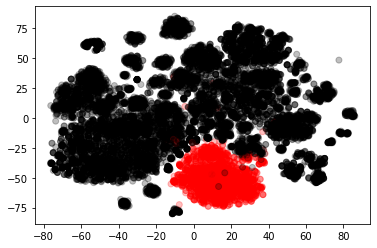

In [22]:
# define class
cls = 'http://rdf.freebase.com/ns/film.film'

# define color map
cmap = {
    True: 'red', # instance of target type
    False: 'black', # not an instance of the target type
}

# assign colors to entities
colors = [cmap[cls in ent2type.get(id2ent[ent], set())]
          for ent in range(len(rescal_ent))]

# plot via matplotlib in 2D space
x, y = zip(*Xvis)
plt.scatter(x, y, c=colors, alpha=0.25)
plt.show()

#### one-vs-one

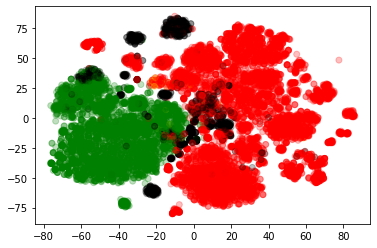

In [23]:
# define types
c0 = 'http://rdf.freebase.com/ns/base.type_ontology.inanimate'
c1 = 'http://rdf.freebase.com/ns/base.type_ontology.animate'

# define color map
cmap = {
    0: 'black',  # no or unknown types
    1: 'red',    # type 0
    2: 'green',  # type 1
    3: 'yellow', # both types
}

# assign colors to entities
colors = [cmap[(c0 in ent2type.get(id2ent[ent], set())) + 2*(c1 in ent2type.get(id2ent[ent], set()))]
          for ent in range(len(rescal_ent))]

# plot via matplotlib in 2D space
x, y = zip(*Xvis)
plt.scatter(x, y, c=colors, alpha=0.25)
plt.show()

### Quantitative: binary <rdf:type> classification

To quantify <rdf:type> inference, we build a battery of classifiers that decide whether or not an entity is an instance of a particular type. Specifically, we create a binary classifier ```clf``` for each type and train it on RESCAL's entity embeddings. Albeit type prediction is a relatively simple task, this setup nicely demonstrates how embeddings would be used in a typical machine learning task like classification. We inspect the overall performance as the average classifier accuracy.

In [24]:
# NOTE: due to the high number of types, the code below can take a bit of time to complete.

# size of the testing set.
test_size = 0.33

acc = dict()
# iterate over all known types
for cls in tqdm(reduce(set.union, ent2type.values())):
    # fetch targets
    Y = np.array([1.0 * (cls in ent2type.get(id2ent[ent], set())) for ent in range(len(rescal_ent))])

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(rescal_ent, Y, test_size=test_size)
    if len(set(y_train)) != 2: continue # skip if there's only one class

    # create and train a classifier
    clf = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
    
    # compute and store the classifier's accuracy
    acc[cls] = accuracy_score(y_test, clf.predict(X_test))

100%|██████████| 3816/3816 [07:33<00:00,  8.41it/s]


In [25]:
# summary statistics in percent
scores = 100 * np.array(list(acc.values()))

print("Average type prediction accuracy", scores.mean())
print("Best type prediction accuracy", scores.max())
print("Worst type prediction accuracy", scores.min())
print("Worst predicted type", [cls for cls, sc in acc.items() if 100 * sc == scores.min()])

Average type prediction accuracy 99.79220907822139
Best type prediction accuracy 100.0
Worst type prediction accuracy 86.76807668264222
Worst predicted type ['http://rdf.freebase.com/ns/base.ontologies.ontology_instance']


## References

[1] https://github.com/uma-pi1/kge

[2] Ruffinelli, Daniel, Samuel Broscheit, and Rainer Gemulla. "You can teach an old dog new tricks! on training knowledge graph embeddings." International Conference on Learning Representations. 2019.

[3] Toutanova, Kristina, and Danqi Chen. "Observed versus latent features for knowledge base and text inference." Proceedings of the 3rd workshop on continuous vector space models and their compositionality. 2015.

[4] Bordes, Antoine, et al. "Translating embeddings for modeling multi-relational data." Neural Information Processing Systems (NIPS). 2013.

[5] Nickel, Maximilian, Volker Tresp, and Hans-Peter Kriegel. "A three-way model for collective learning on multi-relational data." Icml. 2011.